# 5. Sampling (Stage 2b: Sampling)
This Jupyter notebook demonstrates how generate raw AOSLO frames using a ground truth retina and an eye movement trace. We do not yet add the effects of diffraction, aberrations or noise - that will be shown in notebook "6. Image generation". The images shown are 'raw' retinae.


First we import the relevant modules:

In [22]:
%matplotlib inline

import numpy
import os
import sys

from matplotlib import pyplot
from astropy.io import fits
from PIL import Image

from importlib import reload

from ERICA import AOSLO_system, fixation_simulation, sampling, ERICA_toolkit

current_directory = os.getcwd()

We can set where the images will be saved

In [23]:
save_folder_images = os.path.normpath(os.path.join(current_directory, 'Example_images'))
if os.path.isdir(save_folder_images) == 0:
    os.mkdir(save_folder_images)

## 5.1 Set up your AOSLO
As described in notebook "1. Setting up your AOSLO", first we need to create an instance of an AOSLO object based on the <span style='background-color:rgb(206,190,218)'>system parameter file</span>. This allows us to access information about the AOSLO and imaging parameters, such as the wavelength and the scan pattern.


In [24]:
# Specify the AOSLO system parameter file to use
system_parameters_file = 'system_parameters_demo.yaml'
sys.stdout.write('Using parameter file: %s'%system_parameters_file)

# Create the AOSLO instance
myAOSLO = AOSLO_system.AOSLO(os.path.normpath(os.path.join(current_directory, 'System_parameters', system_parameters_file)))


Using parameter file: system_parameters_demo.yaml

Then we set the folder in which the ground truth <span style='background-color:rgb(227,240,218)'>retinal mosaic parameter array</span> is stored:

In [25]:
folder_ground_truth = os.path.normpath(os.path.join(current_directory, 'Retinal_mosaic_parameters_arrays', system_parameters_file.split('.')[0]))


## 5.2 Sample the retina
First start by opening the based on the <span style='background-color:rgb(227,240,218)'>retinal mosaic parameter array</span> and check the contents:

In [26]:
file_name = 'ground_truth_retina_params_fovea.fits'

if os.path.isfile(os.path.normpath(os.path.join(folder_ground_truth, file_name))) == 1:

    #  Open the fits file
    fits_file_contents = fits.open(os.path.normpath(os.path.join(folder_ground_truth, file_name)))
    # Look at the primary HDU
    retinal_mosaic_parameters_from_file = fits_file_contents[0]

    # Look at the contents of the header
    sys.stdout.write('Nasal/temporal (horizontal) eccentricity: %.2f degrees \n'%retinal_mosaic_parameters_from_file.header['Eccentricity_degrees_X'])
    sys.stdout.write('Superior/inferior (vertical) eccentricity: %.2f degrees \n'%retinal_mosaic_parameters_from_file.header['Eccentricity_degrees_Y'])
    sys.stdout.write('Was the mosaic foveated?: %s \n'%retinal_mosaic_parameters_from_file.header['Foveated'])
    sys.stdout.write('Mosaic number used: %i \n'%retinal_mosaic_parameters_from_file.header['Mosaic_number'])
    sys.stdout.write('Variation in cone width (standard deviation): %.2f (microns) \n'%retinal_mosaic_parameters_from_file.header['width_variation'])
    sys.stdout.write('Reflectance distribution mean: %.2f \n'%retinal_mosaic_parameters_from_file.header['reflectance_mean'])
    sys.stdout.write('Reflectance distribution standard deviation: %.2f \n'%retinal_mosaic_parameters_from_file.header['reflectance_stdev'])

    retinal_mosaic_params_microns = retinal_mosaic_parameters_from_file.data
    eccentricity = [retinal_mosaic_parameters_from_file.header['Eccentricity_degrees_Y'], retinal_mosaic_parameters_from_file.header['Eccentricity_degrees_X']]

    
else:
    sys.stdout.write('Retinal mosaic parameter array does not exist: %s'%os.path.normpath(os.path.join(folder_ground_truth, file_name)))
    

Nasal/temporal (horizontal) eccentricity: 0.00 degrees 
Superior/inferior (vertical) eccentricity: 0.00 degrees 
Was the mosaic foveated?: True 
Mosaic number used: 0 
Variation in cone width (standard deviation): 0.10 (microns) 
Reflectance distribution mean: 0.50 
Reflectance distribution standard deviation: 0.15 


Specify some eye movement (<span style='background-color:rgb(243,166,173)'>eye position array</span>) as an array of size (2, number samples). To start with we will try a stationary eye:

In [27]:
eye_motion_arcmin = numpy.zeros((2, myAOSLO.slow.shape[0]))

Perform the scanning  - we'll 'image' at the centre of the mosaic (0.0, 0.0):

In [28]:
eccentricity = [0.0,0.0]

intensity, retina_params_pixels_scanned, fast_scan, slow_scan = sampling.sampleRetina(retinal_mosaic_params_microns, eye_motion_arcmin, myAOSLO.fast, myAOSLO.slow, myAOSLO.parameters['pixel_size_arcmin_y_x'], myAOSLO.parameters['microns_per_degree'], eccentricity_deg = eccentricity)


## 5.3 Reshape the intensity data to form an image
This naively just reshapes the array to be the correct number of lines and number of pixels. If you want to understand how your particular sampling and synchronisation affect the image, that should be programmed here instead.

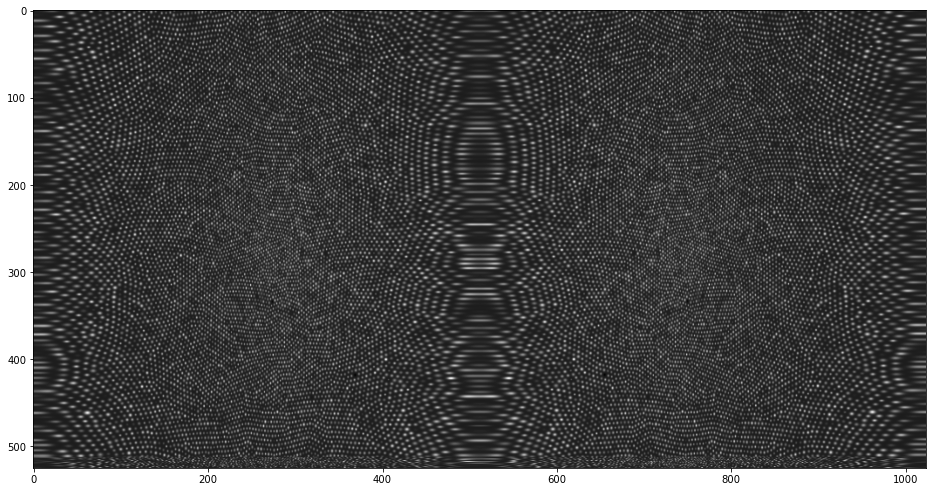

In [29]:
fr_image = intensity.reshape((myAOSLO.parameters['number_scan_lines_including_flyback'],myAOSLO.parameters['number_pixels_per_line']*2))

fig_1 = pyplot.figure(1, figsize=(16,10))
ax1_1 = fig_1.add_subplot(111)
ax1_1.imshow(fr_image, cmap='gray')



The simulation includes the forward and reverse scan of the fast (resonant) scan mirror, so here we select only the forward scan. If you like, you could also remove the galvo flyback/return, which is visible a the bottom of the image.

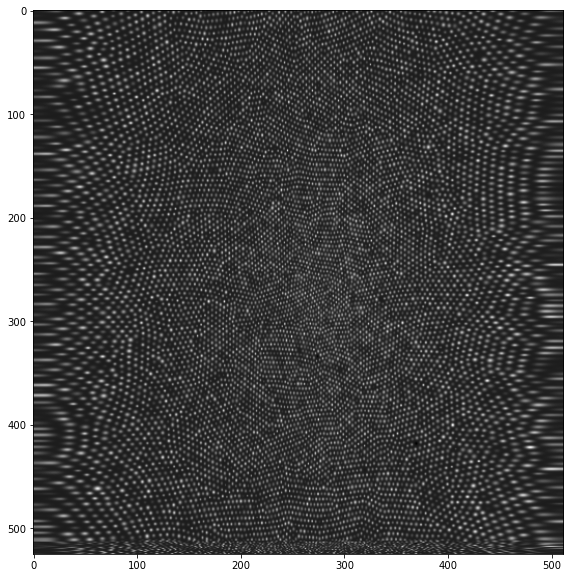

In [30]:
image = fr_image[:,:myAOSLO.parameters['number_pixels_per_line']]

fig_2 = pyplot.figure(2, figsize=(10,10))
ax2_1 = fig_2.add_subplot(111)
ax2_1.imshow(image, cmap='gray')

Next we desinusoid the image, again this is a simple algorithm that uses a perfect sinusoid with a frequency specified by the resonant frequency. If you prefer, you could write your own desinsoiding code to analyse any effects you are interested in (e.g. synchronisation and sampling effects or modeling the process you use in your own system to linearise the fast axis):

In [31]:
image_desinusoid = myAOSLO.desinusoid(image)

Finally, we can show the ground truth retina (<span style='background-color:rgb(240,233,194)'>image</span>) (no effects of diffraction etc.) after desinusoiding and removing the lines at the top which contain the flyback:

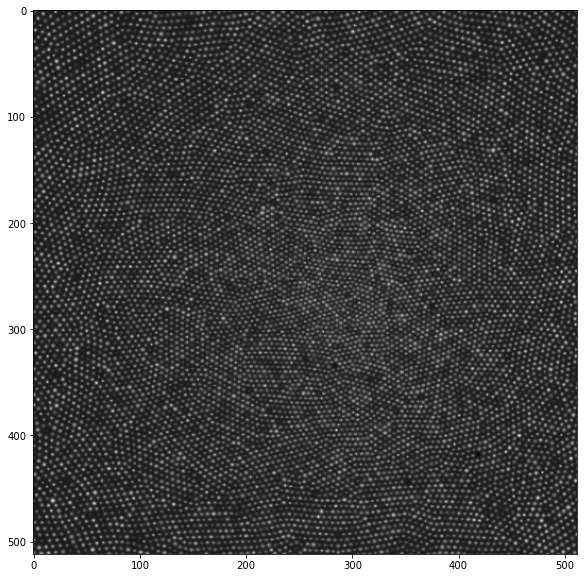

In [32]:
fig_3 = pyplot.figure(3, figsize=(10,10))
ax3_1 = fig_3.add_subplot(111)
nlines_flyback = myAOSLO.parameters['number_scan_lines_including_flyback'] - myAOSLO.parameters['number_scan_lines_excluding_flyback']
ax3_1.imshow(image_desinusoid[:-nlines_flyback], cmap='gray')



We will save this to file to use later when adding diffraction and noise:
    

In [33]:
image_file = os.path.normpath(os.path.join(save_folder_images, 'ground_truth_frame_fovea.bmp'))
sys.stdout.write('Saving ground truth image to: %s'%image_file)


Image.fromarray(ERICA_toolkit.normalise(image_desinusoid[:-nlines_flyback], bits=int(myAOSLO.parameters['bit_depth'])).astype(numpy.uint8)).save(image_file)



Saving ground truth image to: /Users/laurayoung/Documents/Repositories/erica_final/Example_images/ground_truth_frame_fovea.bmp

Let's finally check the ground truth locations:

(0.0, 50.0, 50.0, 0.0)

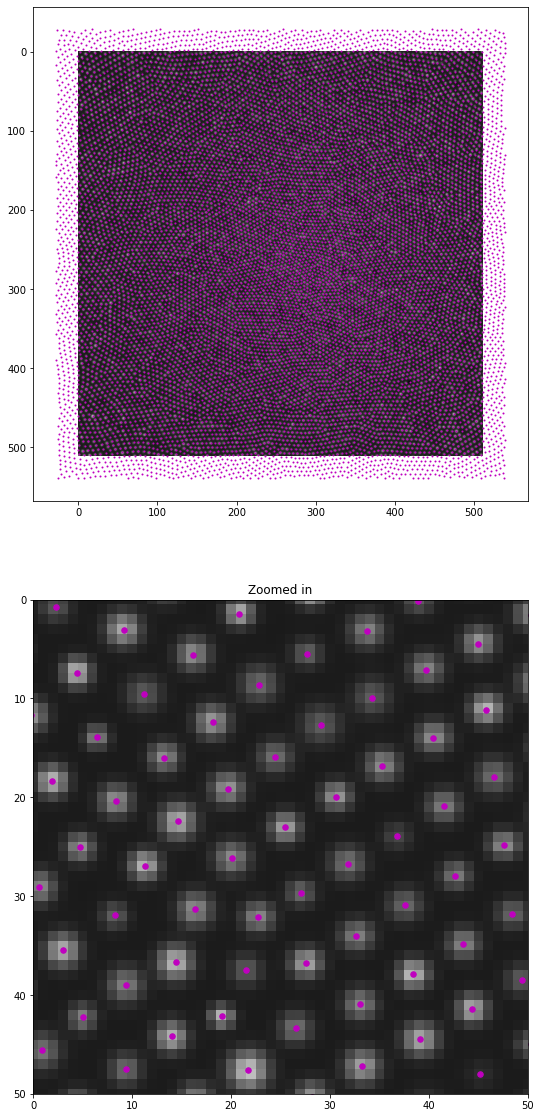

In [34]:
fig_4 = pyplot.figure(4, figsize=(10,20))
ax4_1 = fig_4.add_subplot(211)
# Show the image
ax4_1.imshow(image_desinusoid[:-nlines_flyback], cmap='gray')
# Scatter the ground truth locations
ax4_1.scatter(retina_params_pixels_scanned[1], retina_params_pixels_scanned[0], color='m', s=1)

ax4_2 = fig_4.add_subplot(212)
ax4_2.imshow(image_desinusoid[:-nlines_flyback], cmap='gray')
# Scatter the ground truth locations
ax4_2.scatter(retina_params_pixels_scanned[1], retina_params_pixels_scanned[0], color='m', s=30)
ax4_2.set_title('Zoomed in')
# Reduce the axis limits so we can see the cones and markers more clearly
pyplot.axis([0,50,50,0])

## 5.4 Sampling with an eye movement
Next we will repeat the above with an eye movement. First we set up our oculomotor system (see notebook "04_eye_movement_simulation")

In [35]:
# Eye movements are generated with a lower temporal resolution and then upsampled at the end. This speeds up 
# data generation. The subsampling number should be small, and no larger than number of pixels per scan line, to avoid 
# undersampling. The default is 64
subsample_rate = 64

# Specify the fixational ye motion parameter file to use
fixation_parameters_file = os.path.normpath(os.path.join(current_directory, 'Fixation_parameters', 'fixation_parameters_default.yaml'))
sys.stdout.write('Using parameter file: %s'%system_parameters_file)

# Create an instance of the Fixation object
myEyeMotion = fixation_simulation.Fixation(fixation_parameters_file, myAOSLO.time_resolution, subsamp=subsample_rate)

Using parameter file: system_parameters_demo.yaml

Then we generate a movement (<span style='background-color:rgb(243,166,173)'>microsaccade</span>), in this case, a microsaccade:

In [36]:
# The total time of the eye movement (seconds). Here we will use the time for one frame, which is the sample
# time multiplied by the number of samples per frame
n_frames = 1
total_time = myAOSLO.time_resolution * myAOSLO.n_samples * n_frames

# The number of samples in that time period
n_samples_microsaccade = int(numpy.ceil(total_time / float(myAOSLO.time_resolution)))

# The amplitude of the microsaccade (arcminutes)
microsaccade_amplitude = 15.0

# The direction of the microsaccade (radians), with 0 being along the positive x axis.
microsaccade_angle = numpy.pi / 3.0

# Log of the amplitude in degrees
l = numpy.log10(microsaccade_amplitude / 60.)

# Estimate the maximum speed from the main sequence 
ms = l + numpy.log10(myEyeMotion.parameters['Main_sequence_factor'])
microsaccade_max_speed = 60 * 10**ms       

# Generate the microsaccade
microsaccade_raw = fixation_simulation.microsaccade(microsaccade_amplitude, microsaccade_angle, microsaccade_max_speed, myAOSLO.time_resolution, n_samples=n_samples_microsaccade)

# Set up an array of time samples
time_samp_microsaccade = numpy.linspace(0, microsaccade_raw.shape[1]-1, microsaccade_raw.shape[1]) * myAOSLO.time_resolution



Let's plot it to see what the movement looks like:

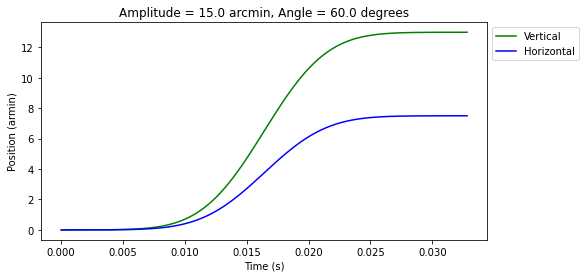

In [37]:
fig_5 = pyplot.figure(5, figsize=(8,4))
ax5_1 = fig_5.add_subplot(111)
ax5_1.plot(time_samp_microsaccade, microsaccade_raw[0], color='g', label='Vertical')
ax5_1.plot(time_samp_microsaccade, microsaccade_raw[1], color='b', label='Horizontal')
ax5_1.set_xlabel('Time (s)')
ax5_1.set_ylabel('Position (armin)')
ax5_1.set_title('Amplitude = %.01f arcmin, Angle = %.01f degrees'%(microsaccade_amplitude,microsaccade_angle * 180.0 / numpy.pi))
ax5_1.legend(bbox_to_anchor=(1,1))

Here, we can also offset the eye position if we want to. The variable "eccentricity_fixation" is the eccentricity of the eye position and "eccentricity_image" is the eccentricity of the retinal mosaic parameter array (i.e. where on the retina we are imaging).

For example, the foveal mosaic we are using was generated for an eccentricity of (0.0, 0.0) and we want to image a location (-0.4, 0.0) in fundus view - i.e. 0.4 degrees inferior to the anatomical fovea. The participant is fixating eccentrically and their fixation point (in the real world) is (0.4, 0.0) - i.e. they are looking vertically upwards by 0.4 degrees.

In [38]:
eccentricity_fixation = [0.4,0.0]
sys.stdout.write('The fixation point is at an eccentricity of (Y, X; degrees): %.2f, %.2f'%(eccentricity_fixation[0], eccentricity_fixation[1]))
microsaccade = numpy.copy(microsaccade_raw)
microsaccade[0] += eccentricity_fixation[0] * 60
microsaccade[1] += eccentricity_fixation[1] * 60

eccentricity_image = [-0.4,0.0]


The fixation point is at an eccentricity of (Y, X; degrees): 0.40, 0.00

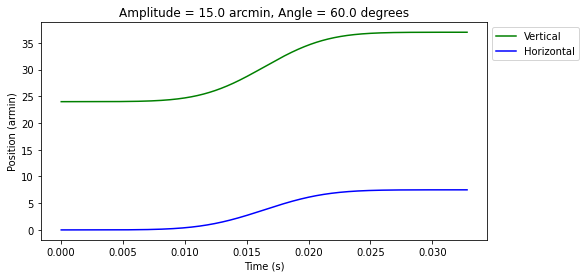

In [39]:
fig_6 = pyplot.figure(6, figsize=(8,4))
ax6_1 = fig_6.add_subplot(111)
ax6_1.plot(time_samp_microsaccade,microsaccade[0], color='g', label='Vertical')
ax6_1.plot(time_samp_microsaccade,microsaccade[1], color='b', label='Horizontal')
ax6_1.set_xlabel('Time (s)')
ax6_1.set_ylabel('Position (armin)')
ax6_1.set_title('Amplitude = %.01f arcmin, Angle = %.01f degrees'%(microsaccade_amplitude,microsaccade_angle * 180.0 / numpy.pi))

ax6_1.legend(bbox_to_anchor=(1,1))

Now we will scan with this movement. This can take a few seconds and will take longer at lower eccentricities where there are more cones:

In [40]:
microsaccade_arcmin = numpy.copy(microsaccade)
intensity_microsaccade, retina_params_pixels_scanned_microsaccade, fast_plus_em, slow_plus_em = sampling.sampleRetina(retinal_mosaic_params_microns, microsaccade_arcmin, myAOSLO.fast, myAOSLO.slow, myAOSLO.parameters['pixel_size_arcmin_y_x'], myAOSLO.parameters['microns_per_degree'], eccentricity_deg=eccentricity_image)


Then, reshape the intensity data into an image:

In [41]:
fr_image_microsaccade = intensity_microsaccade.reshape((myAOSLO.parameters['number_scan_lines_including_flyback'],myAOSLO.parameters['number_pixels_per_line']*2))
image_microsaccade = fr_image_microsaccade[:,:myAOSLO.parameters['number_pixels_per_line']]
image_desinusoid_microsaccade = myAOSLO.desinusoid(image_microsaccade)

And then we can see what effect that has on the ground truth image (excluding diffraction etc.):

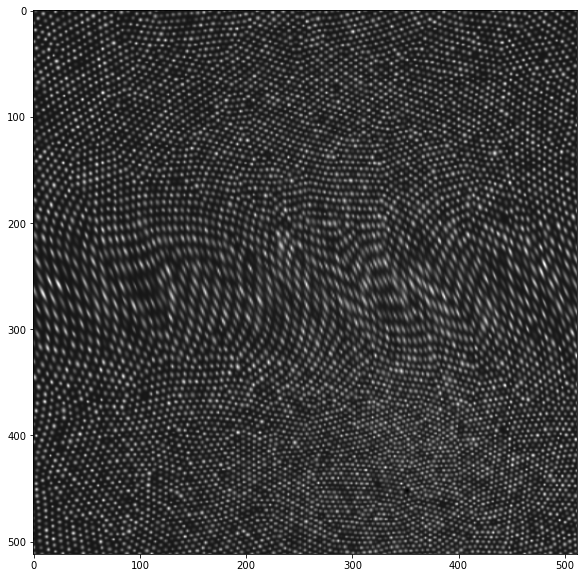

In [42]:
fig_6 = pyplot.figure(6, figsize=(10,10))
ax6_1 = fig_6.add_subplot(111)
ax6_1.imshow(image_desinusoid_microsaccade[:-nlines_flyback], cmap='gray')

Looking at the motion trace, the eye's gaze is moving at 60 degrees in a positve x and positive y direction. <br>
<br>
A positive vertical movement is the participant looking upward. As the participant looks upward the retina moves downward relative to the AOSLO beam. The vertical scanner moves from top (line 0) to bottom (line 511). So, this means that the AOSLO beam is scanning downward and the retina is moving downward, so the image should be stretched vertically (the relative velocity between the AOSLO beam and the retina is lower, so the same patch of retina is exposed for longer) .<br>
<br>
A positive horizontal movement is the participant looking rightward. As the participant looks to the right, the retina appears to move rightward in fundus view, looking into the eye. We therefore expect to see rightward movement in the images - in the stretched area, the bottoms of the cones (the later time point) should be to the right of the tops of the cones (earlier time points).<br>
<br>
It should be noted that the amount of stretch/compression apparent in the images will depend not only on the speed of the microsaccade but also on the speed of the scanning mirrors, most notably the slow scanner. So, images will look more or less stretched/compressed as the field of view (pixel size or number of scan lines) changes or the slow scan frequency changes.<br>
<br>
Finally, we set this up so that the imaging eccentricity was (-0.4, 0.0) in fundus view - 0.4 degrees inferior to the foveal centre. We also set the participant's fixation point to be (0.4, 0.0) - 0.4 degrees vertically upward in the real world. This would cause the AOSLO beam to be repositioned 0.4 degrees higher and so this cancels out the 0.4 degree inferior offset that we were imaging at - we should see an image of the foveal centre, though of course this is slightly offset by the eye movement.
